In [1]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
#from libra_py import *
from libra_py import units
from libra_py import QE_methods
from libra_py import scan

from libra_py import hpc_utils
from libra_py import data_read
from libra_py import data_outs
from libra_py import data_conv
from libra_py.workflows.nbra import step2


import py3Dmol   # molecular visualization
import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::complex<double>, std::allocator<std::complex<double> > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  if __name__ == '__main__':
/home/alexey/miniconda2/envs/libra/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<in

### 1. Contributions to energy

In [44]:
s = []
Etot, Eband, Ehart, Vtxc, Etxc, Ewald = [], [], [], [], [], []

#mytot = []

for i in xrange(16):
    s.append(i)
    
    ctx = Context("res/x0_data-file-schema_%s.xml" % i)  
    ctx.set_path_separator("/")

    Etot.append( ctx.get("output/total_energy/etot",-1.0)  )
    Eband.append( ctx.get("output/total_energy/eband",-1.0)  )
    Ehart.append( ctx.get("output/total_energy/ehart",-1.0)  )
    Vtxc.append( ctx.get("output/total_energy/vtxc",-1.0)  )
    Etxc.append( ctx.get("output/total_energy/etxc",-1.0)  )
    Ewald.append( ctx.get("output/total_energy/ewald",-1.0)  )
    
    # I'm guessing how the total energy in QE is computed
    #mytot.append(Eband[i] - 0.5* Ehart[i] + Ewald[i] - Etxc[i] + Vtxc[i]) # + Etxc[i] + Ewald[i])

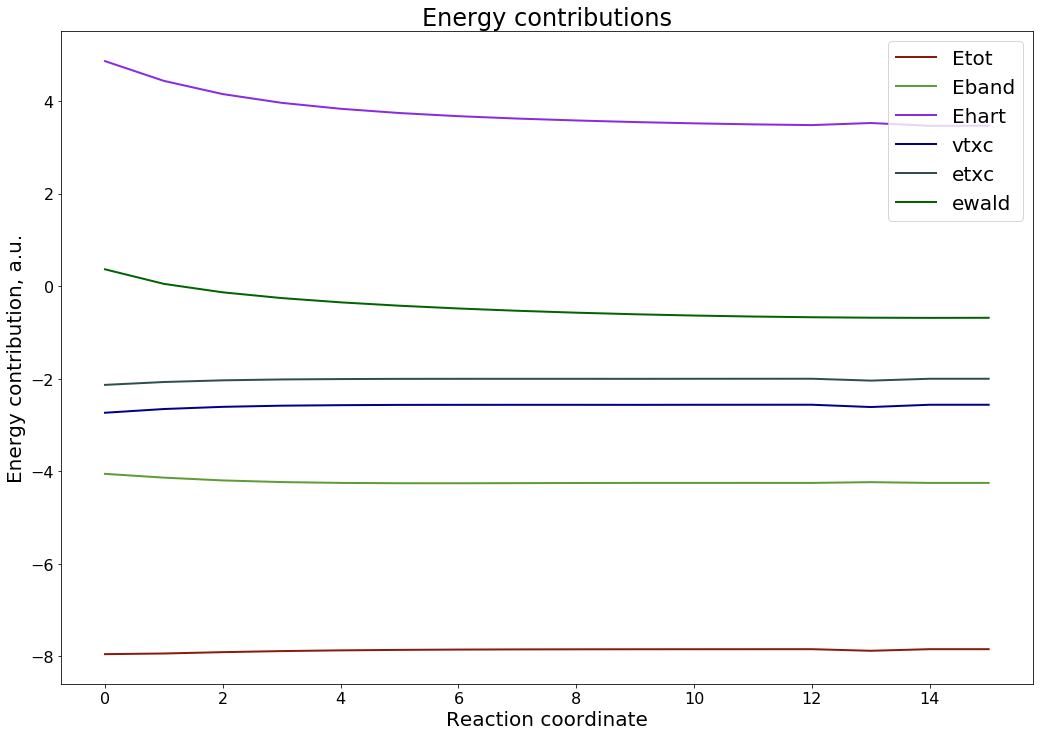

In [45]:
plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Energy contributions')
plt.xlabel('Reaction coordinate')
plt.ylabel('Energy contribution, a.u.')

plt.plot(s, Etot, label='Etot', linewidth=2, color = colors["11"]) 
plt.plot(s, Eband, label='Eband', linewidth=2, color = colors["21"]) 
plt.plot(s, Ehart, label='Ehart', linewidth=2, color = colors["31"]) 
plt.plot(s, Vtxc, label='vtxc', linewidth=2, color = colors["32"]) 
plt.plot(s, Etxc, label='etxc', linewidth=2, color = colors["41"]) 
plt.plot(s, Ewald, label='ewald', linewidth=2, color = colors["22"]) 
#plt.plot(s, mytot, "ro", label='my etot', linewidth=2, color = colors["11"]) 

plt.legend()
plt.show()
plt.close()

### 2. Magnetization

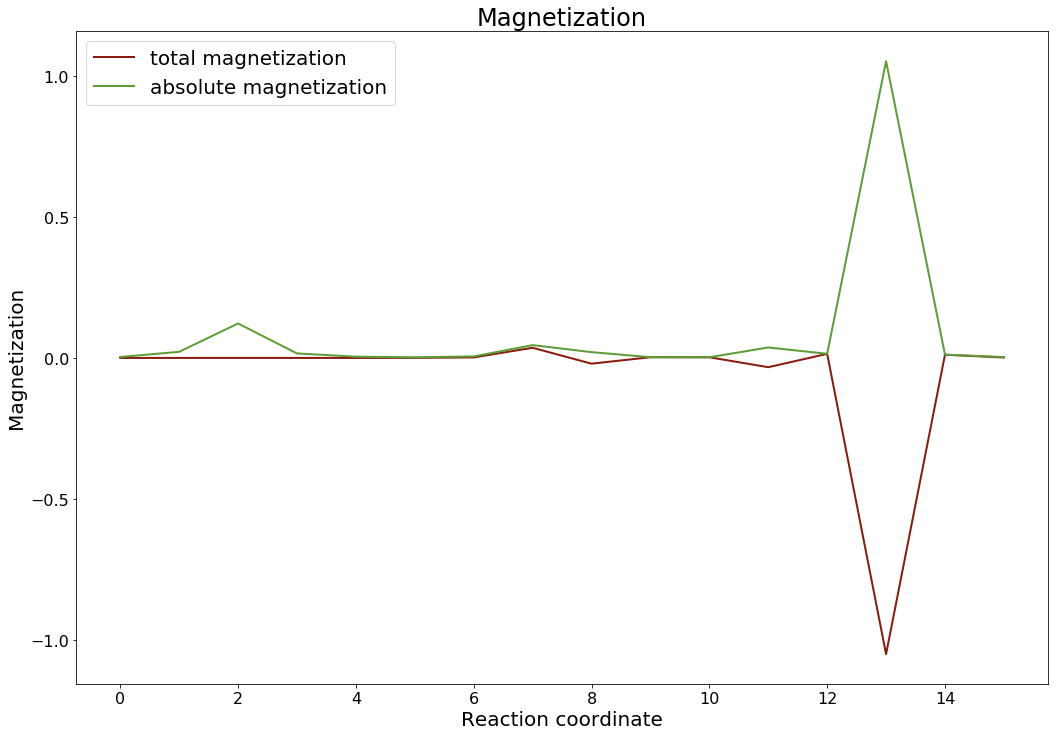

In [46]:
s = []
mag_tot, mag_abs = [], []

#mytot = []

for i in xrange(16):
    s.append(i)
    
    ctx = Context("res/x0_data-file-schema_%s.xml" % i)  
    ctx.set_path_separator("/")

    mag_tot.append( ctx.get("output/magnetization/total",-1.0)  )
    mag_abs.append( ctx.get("output/magnetization/absolute",-1.0)  )
    
    

plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Magnetization')
plt.xlabel('Reaction coordinate')
plt.ylabel('Magnetization')

plt.plot(s, mag_tot, label='total magnetization', linewidth=2, color = colors["11"]) 
plt.plot(s, mag_abs, label='absolute magnetization', linewidth=2, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### 3. Band structure

In [50]:
s = []
band = []

for i in xrange(16):
    s.append(i)
    
    ctx = Context("res/x0_data-file-schema_%s.xml" % i)  
    ctx.set_path_separator("/")

    band_str = ctx.get("output/band_structure/ks_energies/eigenvalues","")
    tmp = band_str.split()
    nband = len(tmp)
    e = MATRIX(nband, 1)
    for n in xrange(nband):
        e.set(n, 0, float(tmp[n]))
        
    band.append(e)   

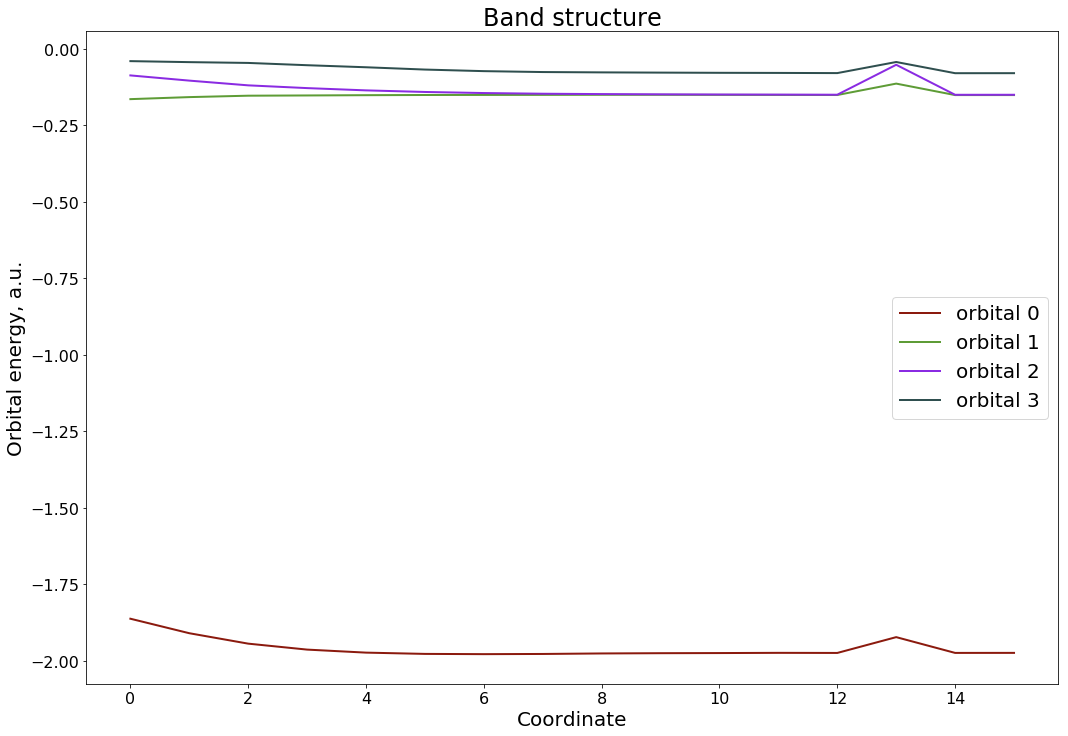

In [53]:
plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Band structure')
plt.xlabel('Coordinate')
plt.ylabel('Orbital energy, a.u.')

for i in [0,1,2,3]:
    e = data_conv.unpack1(band, i, 0, 2)
    
    plt.plot(s, e, label='orbital %i' % (i), linewidth=2, color = colors[clrs_index[i]]) 
    plt.legend()
    
plt.show()
plt.close()